# Extracción de características y creación de dataset (.csv)

## Importar librerías

In [81]:
pip install biosignalsnotebooks

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import pywt
from scipy import signal
from scipy.signal import iirnotch, freqz, find_peaks, lfilter, welch
import biosignalsnotebooks as bsnb
import csv
import pandas as pd

## Leemos la señal sin filtrar del archivo de texto

In [88]:
arrayeeg = np.genfromtxt("eegSignalUC - Reposo.txt", delimiter=",",skip_header = 5, missing_values= 0)
#Extraemos la columna de la señal y creamos sus respectivos vectores tiempos
signaleeg = arrayeeg[:, 5]
signaleeg_3000 = signaleeg[500:1100]
Fs_eeg = 1000
Ts_eeg = 1/Fs_eeg
n_eeg= len(signaleeg)
t_eeg = np.arange(0,n_eeg*Ts_eeg,Ts_eeg)
t_eeg_3000 = np.arange(0,600*Ts_eeg ,Ts_eeg)
t_eeg


array([0.000e+00, 1.000e-03, 2.000e-03, ..., 7.497e+00, 7.498e+00,
       7.499e+00])

## Aplicamos DWT para filtrar la señal

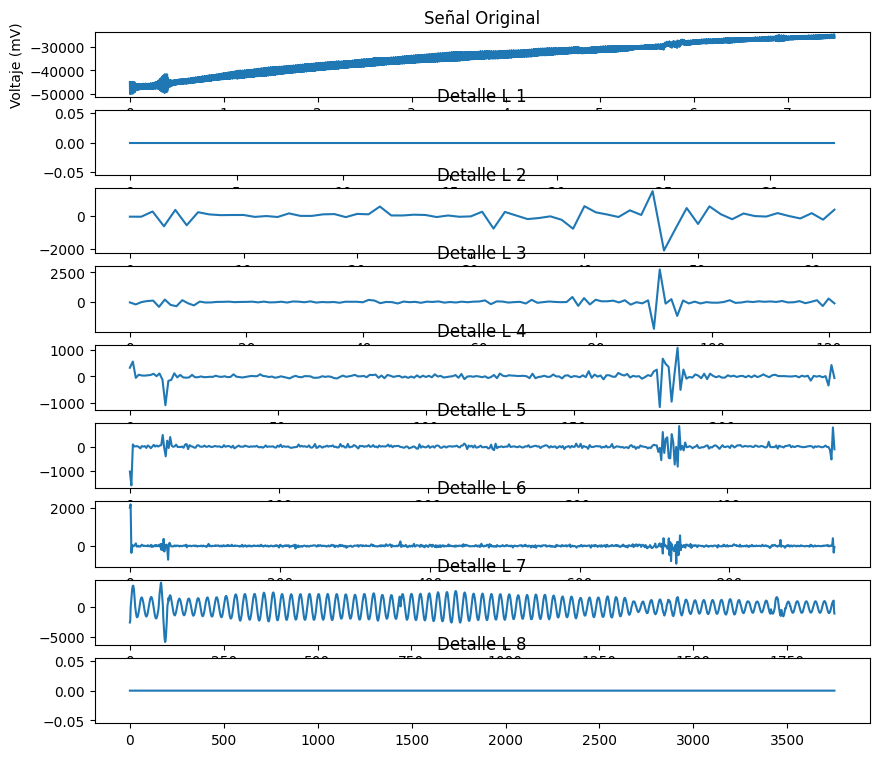

In [91]:
niveles_eeg = 8
coeficientes_eeg = pywt.wavedec(signaleeg, 'sym3', level=niveles_eeg)
coeficientes_eeg[0] = 0 * coeficientes_eeg[0]
coeficientes_eeg[1] = 0 * coeficientes_eeg[1]
coeficientes_eeg[8] = 0 * coeficientes_eeg[8]

plt.figure(figsize=(10, 10))
plt.subplot(niveles_eeg + 2, 1, 1)
plt.plot(t_eeg,signaleeg)
plt.ylabel('Voltaje (mV)')
plt.xlabel('Tiempo (s)')
plt.title('Señal Original')

for i, detalle in enumerate(coeficientes_eeg[1:]):  # Empezar desde el segundo nivel
    plt.subplot(niveles_eeg + 2, 1, i + 2)
    plt.plot(detalle)
    plt.title(f'Detalle L {i+1}')


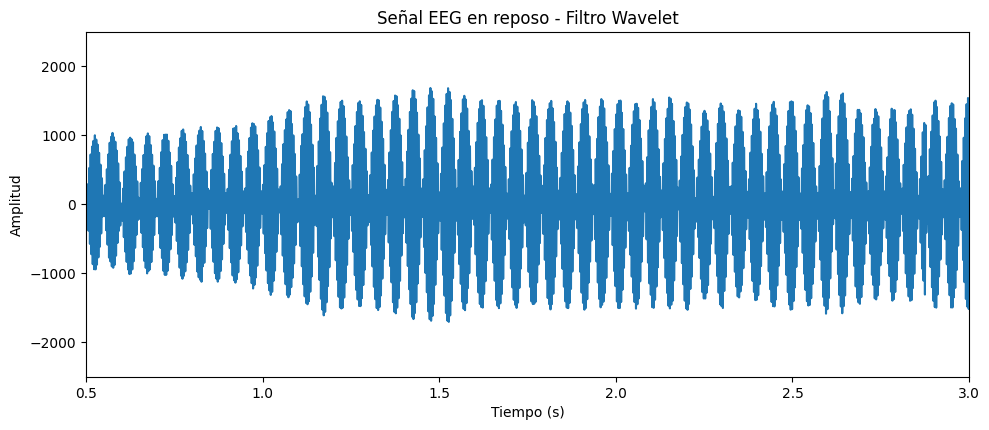

In [92]:
umbral = 0.05

coeficientes_umbral_eeg = [pywt.threshold(c, umbral, mode='soft') for c in coeficientes_eeg]


senal_filtrada_eeg = pywt.waverec(coeficientes_umbral_eeg, 'sym3')

plt.figure(figsize=(10, 8))


plt.subplot(2, 1, 2)
plt.plot(t_eeg, senal_filtrada_eeg)
plt.xlim(0.5,3)
plt.ylim(-2500,2500)
plt.title('Señal EEG en reposo - Filtro Wavelet')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()

## Separación de bandas de frecuencia

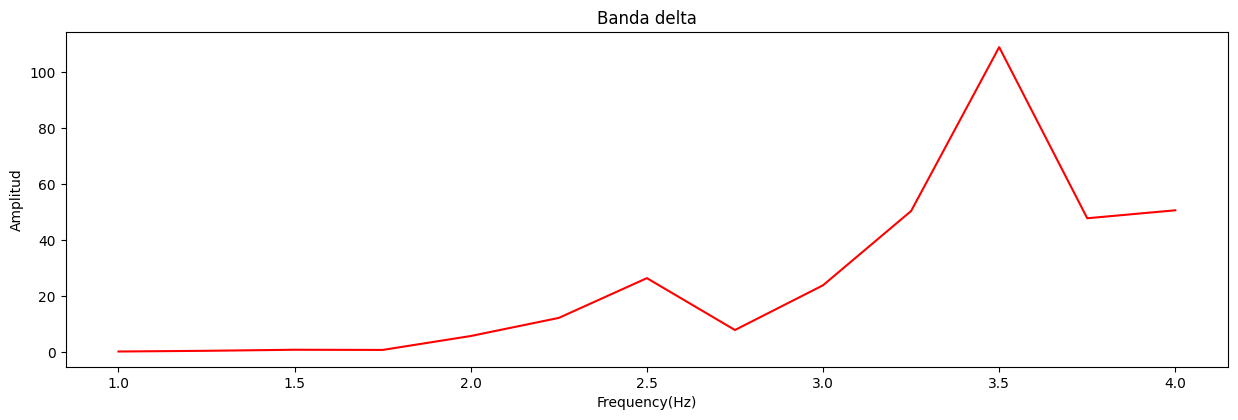

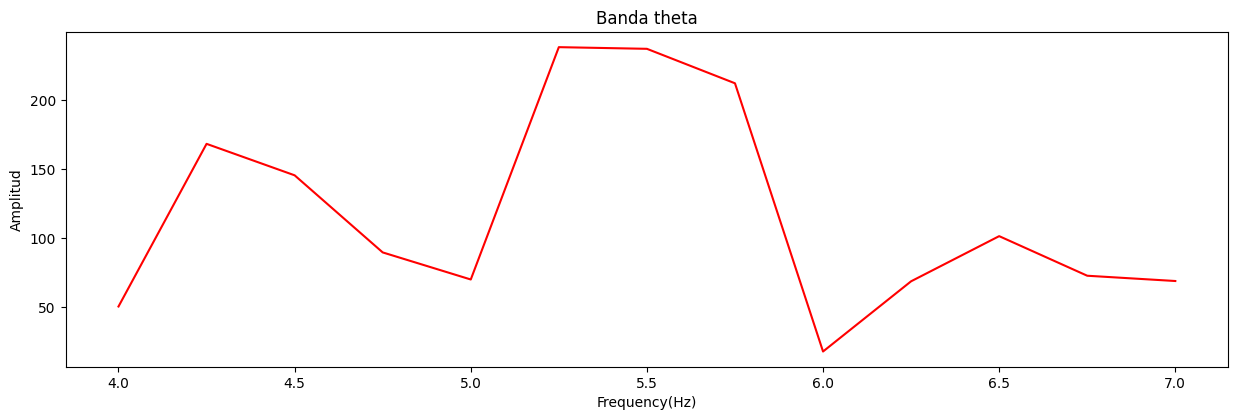

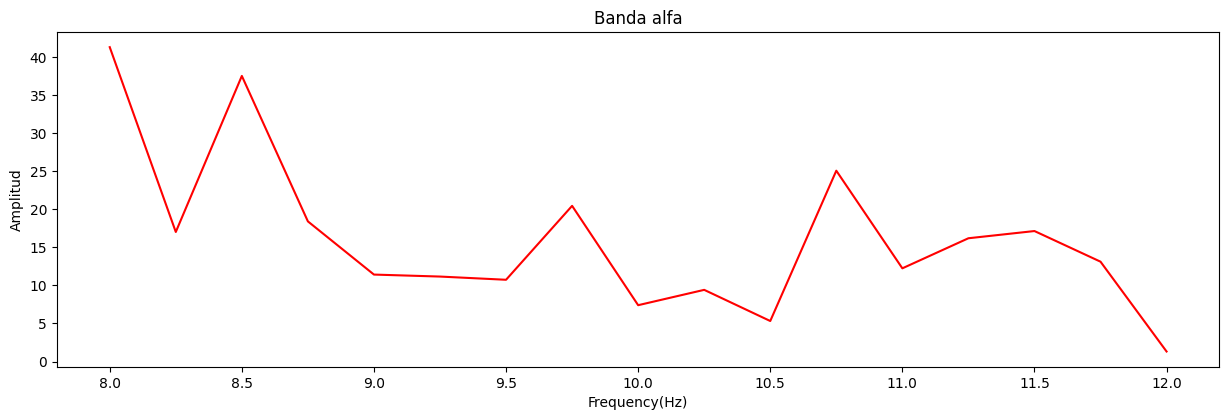

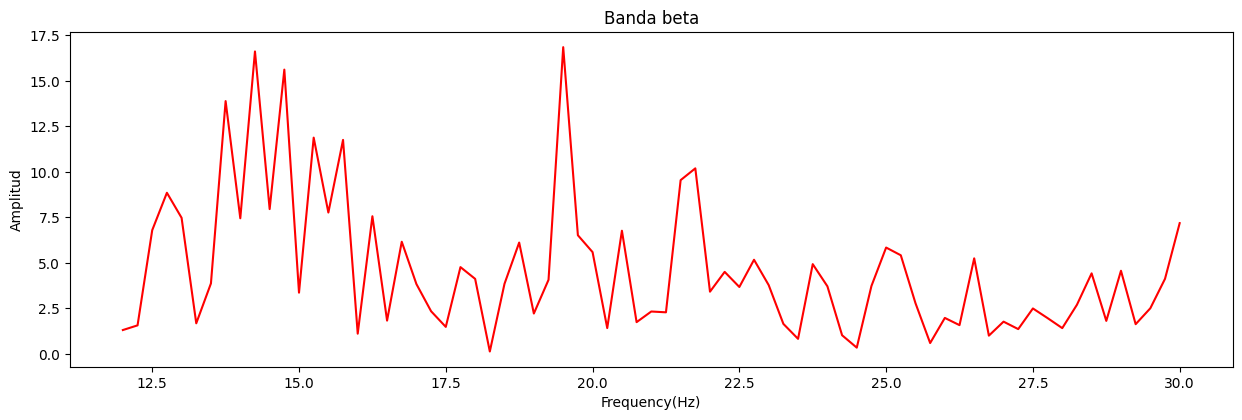

In [93]:
#Time Windows for Welchs method - Delta band

sr=1000
win = 4 * sr # 4 seconds time windows.

#FFT with time windows using scipy.signal.welch
axis_x_1, axis_y_1 = welch(senal_filtrada_eeg, sr, nperseg=win)


freq_low = 1  #lower limit for alpha band
freq_high = 4 #Upper limit for alpha band

Signal_1 = np.logical_and(axis_x_1 >= freq_low, axis_x_1 <= freq_high)


fig2 = plt.figure(figsize=(15,20))

plt.subplot(4, 1, 1); plt.plot(axis_x_1[Signal_1], axis_y_1[Signal_1], "r"); plt.xlabel("Frequency(Hz)"); plt.title("Banda delta");
plt.ylabel("Amplitud");

#Time Windows for Welchs method -  Theta band
sr=1000
win = 4 * sr # 4 seconds time windows.

#FFT with time windows using scipy.signal.welch
axis_x_1, axis_y_1 = welch(senal_filtrada_eeg, sr, nperseg=win)


freq_low = 4 #lower limit for alpha band
freq_high = 7 #Upper limit for alpha band
Signal_1 = np.logical_and(axis_x_1 >= freq_low, axis_x_1 <= freq_high)


fig2 = plt.figure(figsize=(15,20))

plt.subplot(4, 1, 1); plt.plot(axis_x_1[Signal_1], axis_y_1[Signal_1], "r"); plt.xlabel("Frequency(Hz)"); plt.title("Banda theta");
plt.ylabel("Amplitud");

#Time Windows for Welchs method -  Alpha band
sr=1000
win = 4 * sr # 4 seconds time windows.

#FFT with time windows using scipy.signal.welch
axis_x_1, axis_y_1 = welch(senal_filtrada_eeg, sr, nperseg=win)


freq_low = 8 #lower limit for alpha band
freq_high = 12 #Upper limit for alpha band

Signal_1 = np.logical_and(axis_x_1 >= freq_low, axis_x_1 <= freq_high)


fig2 = plt.figure(figsize=(15,20))

plt.subplot(4, 1, 1); plt.plot(axis_x_1[Signal_1], axis_y_1[Signal_1], "r"); plt.xlabel("Frequency(Hz)"); plt.title("Banda alfa");
plt.ylabel("Amplitud");
#Time Windows for Welchs method -  Alpha band
sr=1000
win = 4 * sr # 4 seconds time windows.
#FFT with time windows using scipy.signal.welch
axis_x_1, axis_y_1 = welch(senal_filtrada_eeg, sr, nperseg=win)


freq_low = 12 #lower limit for alpha band
freq_high = 30 #Upper limit for alpha band

Signal_1 = np.logical_and(axis_x_1 >= freq_low, axis_x_1 <= freq_high)


fig2 = plt.figure(figsize=(15,20))

plt.subplot(4, 1, 1); plt.plot(axis_x_1[Signal_1], axis_y_1[Signal_1], "r"); plt.xlabel("Frequency(Hz)"); plt.title("Banda beta");
plt.ylabel("Amplitud");


## Extracción de características y almacenamiento en un archivo .csv

In [100]:
caracteristicas_dataset = []

#Partimos la señal en segmentos de 5 segundos y obtenemos las características de cada segmento
for i in range (0,10000, 5000):
  eeg_5s = senal_filtrada_eeg[i:i+5000]
  t_eeg = t_eeg[i:i+5000]
  tachogram_data, tachogram_time = bsnb.tachogram(eeg_5s, Fs_eeg, signal=True, out_seconds=True)
  tachogram_data_NN, tachogram_time_NN = bsnb.remove_ectopy(tachogram_data, tachogram_time)

  # Maximum, Minimum and Amplitude
  max_value = max(tachogram_data_NN)
  min_value = min(tachogram_data_NN)
  amplitude = max_value - min_value

  #Mean, median, std and variance
  mean = np.mean(tachogram_data_NN)
  median_val = np.median(tachogram_data_NN)
  std_val = np.std(tachogram_data_NN)
  variance = np.var(tachogram_data_NN)

  time_param_dict = {"Maximum Value": max_value,
                     "Minimum Value": min_value,
                     "Amplitude": amplitude,
                     "Mean": mean,
                     "Median": median_val,
                     "Standard deviation": std_val,
                     "Variance": variance
                     }
  caracteristicas_dataset.append(time_param_dict)

#Almacenamos las características extraídas en un archivo CSV.
df = pd.DataFrame(caracteristicas_dataset)
nombre_archivo = 'DataSet_EEG_Reposo.csv'
df.to_csv(nombre_archivo, index=True, sep=',')

print(f'Los resultados se han guardado en el archivo CSV: {nombre_archivo}')

Los resultados se han guardado en el archivo CSV: DataSet_EEG_Reposo.csv


In [101]:
#Descargamos el archivo.
from google.colab import files
files.download(nombre_archivo)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>